In [1]:
from theFuncs import *

# DATA

In [2]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [3]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [4]:
ticker_data = get_ticker_data_multisource(
    sp100_tickers, 
    start="2019-01-02", 
    end="2021-11-01"
)
#start=2019-01-02
#end=2021-11-01

ERROR:root:ERROR


In [5]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [6]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [7]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [8]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    try:
        model = RollingOLS.from_formula(
            "(ret - DTB3) ~ (spy_ret - DTB3)", 
            data = ticker_data.loc[ticker], 
            window = 66
        ).fit(params_only=True)

        temp = model.params
        temp.columns = ["alpha", "Beta"]
        temp['ticker'] = ticker
        temp.set_index('ticker', inplace=True, append=True)
        temp = temp.reorder_levels(['ticker', 'date']).sort_index()
        df = pd.concat(
            [ 
                df, 
                temp
            ]
        )
    except:
        continue

ticker_data = ticker_data.join(df)

ticker_data.head()

high        low       open      close       volume  \
ticker date                                                                  
AAPL   2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0   
       2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0   
       2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0   
       2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0   
       2019-01-09  38.632500  37.407501  37.822498  38.327499  180396400.0   

                        ret   spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                             
AAPL   2019-01-03 -0.099607  232.998627  0.0236 -0.023863    NaN   NaN  
       2019-01-04  0.042689  240.803085  0.0237  0.033496    NaN   NaN  
       2019-01-07 -0.002226  242.701736  0.0241  0.007885    NaN   NaN  
       2019-01-08  0.019063  244.981995  0.0241  0.009395    NaN   NaN  
       2019-01-09  0.016982  246.126907  0.0240  0.004673    NaN   NaN

In [9]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  8.689088e+09
       2019-01-07  8.103280e+09
       2019-01-08  6.184564e+09
       2019-01-09  6.914143e+09

In [10]:
market_caps = market_caps.ewm(66).mean()

In [11]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  1.082024e+10
       2019-01-07  9.900934e+09
       2019-01-08  8.950780e+09
       2019-01-09  8.531111e+09

In [12]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.099607,-0.032949,-0.047194,-0.034142,-0.039498,-0.021959,-0.015216,0.005997,-0.025242,-0.088951,...,-0.027270,-0.037016,-0.028392,-0.014024,-0.036037,0.003570,-0.010435,-0.007882,-0.005142,-0.015354
2019-01-04,0.042689,0.032217,0.028541,0.038884,0.048632,0.036903,0.034184,0.003995,0.050064,0.009828,...,0.011695,0.038514,0.034833,0.024726,0.043081,0.002490,0.033269,0.029633,0.006246,0.036870
2019-01-07,-0.002226,0.014595,0.014976,0.003473,0.013573,0.005724,0.013457,0.006190,0.034353,0.020366,...,0.001920,0.006241,-0.003376,-0.004698,0.018032,0.006388,0.005750,-0.006465,0.011772,0.005200
2019-01-08,0.019063,0.004648,-0.012006,0.025290,0.014918,0.003959,0.012824,0.011300,0.016612,-0.008026,...,0.013371,0.087270,0.000103,0.006436,0.005439,0.029267,0.020009,-0.002099,0.006981,0.007271
2019-01-09,0.016982,-0.032823,0.016691,0.005030,0.011819,0.014543,-0.001196,-0.008753,0.001714,0.043250,...,0.001439,-0.002587,0.005132,0.010659,0.011769,-0.022782,0.012050,0.005469,-0.003256,0.005275


In [13]:
rolling_correlations = ticker_data_wide.rolling(66).corr().fillna(0)
rolling_correlations.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 100 columns]

In [14]:
filter_correlations = rolling_correlations.groupby(["date"]).sum().sum(axis=1)
filter_correlations_dates = filter_correlations[filter_correlations > 0].index
rolling_correlations = rolling_correlations.loc[filter_correlations_dates]

In [15]:
rolling_covariances = ticker_data_wide.rolling(66).cov().fillna(0)
rolling_covariances.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 100 columns]

In [16]:
filter_covariances = rolling_covariances.groupby(["date"]).sum().sum(axis=1)
filter_covariances_dates = filter_covariances[filter_covariances > 0].index
rolling_covariances = rolling_covariances.loc[filter_covariances_dates]

In [17]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

date        ticker
2019-06-24  AAPL      0.000275
Name: AAPL, dtype: float64

In [18]:
# ticker_data.to_csv("data/test_run/ticker_data.csv")
# ticker_data_wide.to_csv("data/test_run/ticker_data_wide.csv")
# rolling_correlations.to_csv("data/test_run/rolling_correlations.csv")
# rolling_covariances.to_csv("data/test_run/rolling_covariances.csv")
# market_caps.to_csv("data/test_run/market_caps.csv")

In [19]:
# ticker_data = pd.read_csv("data/test_run/ticker_data.csv", index_col=[0, 1], parse_dates=True)
# ticker_data_wide = pd.read_csv("data/test_run/ticker_data_wide.csv", index_col=0, parse_dates=True)
# rolling_correlations = pd.read_csv("data/test_run/rolling_correlations.csv", index_col=[0, 1], parse_dates=True)
# rolling_covariances = pd.read_csv("data/test_run/rolling_covariances.csv", index_col=[0, 1], parse_dates=True)
# market_caps = pd.read_csv("data/test_run/market_caps.csv", index_col=[0, 1], parse_dates=True)

# CLUSTERING

In [20]:
date = get_closest_trading_day("2007-07-07", rolling_correlations)
K = 10

In [21]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MAXIMIZE)

Academic license - for non-commercial use only - expires 2022-08-27
Using license file /Users/karimlayoun/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10101 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0xb8f3082b
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 31.0070853
Presolve time: 0.05s
Presolved: 10101 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)

Root relaxation: objective 6.457578e+01, 665 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     

# INDEX BY CLUSTER WEIGHTS

In [22]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [23]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [24]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(1.0648249531331049, 1.0335923745882458)

In [25]:
portfolio_returns - spy_returns

0.031232578544859058

In [26]:
get_portfolio_beta(center_weights, date, ticker_data)

1.0513020677336924

In [27]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [28]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 94 rows, 100 columns and 490 nonzeros
Model fingerprint: 0x28bde191
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 3e+00]
  Objective range  [7e-06, 4e-04]
  QObjective range [1e-07, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 91 rows and 90 columns
Presolve time: 0.00s
Presolved: 3 rows, 11 columns, 31 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 6.600e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.81429618e+05 -1.81509324e+05  8.08e+03 2.30e-03  3.57e+05     0s
   1   7.

In [29]:
obj

0.0043476695793511376

In [30]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(1.0716980946686974, 1.0335923745882458)

In [31]:
mean_var_step_return - spy_returns

0.038105720080451544

In [32]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

0.8304965833305075

# Method Comparison

In [33]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
HON,5.715331e-01,0.161076
EXC,1.877284e-01,0.063112
MA,1.640978e-01,0.334284
GM,4.311554e-02,0.012158
PG,3.352406e-02,0.027788
GOOGL,6.741872e-07,0.143789
JPM,1.680386e-07,0.120934
MRK,1.495577e-07,0.091617
KHC,6.255835e-08,0.008812
CVS,3.646208e-08,0.036430


# Master Func

In [34]:
start_date = get_closest_trading_day("2000-01-01", rolling_correlations)
end_date = max(ticker_data.index.get_level_values("date"))

master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

while start_date < end_date:
    master_func(
        start_date, 
        10, 
        rolling_correlations, 
        market_caps, 
        ticker_data, 
        ticker_data_wide, 
        rolling_covariances,
        0.5, 
        1.5, 
        1e-3, 
        master_cluster_index,
        master_cluster_performance,
        master_mean_var_index,
        master_mean_var_performance, 
        # GRB.MINIMIZE
        )

    start_date += relativedelta(months=3)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10101 rows, 10100 columns and 30100 nonzeros
Model fingerprint: 0xb8f3082b
Variable types: 0 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 31.0070853
Presolve time: 0.05s
Presolved: 10101 rows, 10100 columns, 30100 nonzeros
Variable types: 0 continuous, 10100 integer (10100 binary)

Root relaxation: objective 6.457578e+01, 665 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      64.5757751   64.57578  0.00%     -    0s

Explored 0 nodes (665 simplex iterations) in 0.09 seconds
Thread count was

In [35]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
2019-04-08 CVS    0.036430
           EXC    0.063112
           GM     0.012158
           GOOGL  0.143789
           HON    0.161076
...                    ...
2021-10-08 JNJ    0.068622
           MDLZ   0.044071
           MET    0.164777
           RTX    0.064701
           SO     0.012136

[110 rows x 1 columns]

<AxesSubplot:>

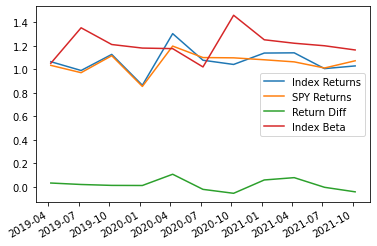

In [36]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.plot()

In [37]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

weight
2019-04-08 CVS    3.646208e-08
           EXC    1.877284e-01
           GM     4.311554e-02
           GOOGL  6.741872e-07
           HON    5.715331e-01
...                        ...
2021-10-08 JNJ    9.102497e-08
           MDLZ   6.115375e-08
           MET    2.978807e-01
           RTX    3.889608e-04
           SO     2.062232e-04

[110 rows x 1 columns]

In [38]:
# method2_index.index.names = ['date', 'ticker']

<AxesSubplot:>

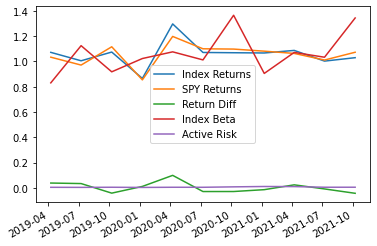

In [39]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.plot()

In [40]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix=" method 1", 
    rsuffix=" method 2"
)
comp_index

weight method 1  weight method 2
2019-04-08 CVS           0.036430     3.646208e-08
           EXC           0.063112     1.877284e-01
           GM            0.012158     4.311554e-02
           GOOGL         0.143789     6.741872e-07
           HON           0.161076     5.715331e-01
...                           ...              ...
2021-10-08 JNJ           0.068622     9.102497e-08
           MDLZ          0.044071     6.115375e-08
           MET           0.164777     2.978807e-01
           RTX           0.064701     3.889608e-04
           SO            0.012136     2.062232e-04

[110 rows x 2 columns]

In [41]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix=" Method 1", 
    rsuffix=" Method 2"
).fillna(method="ffill")
comp_performance

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
2019-04-08,1.064825,1.033592,0.031233,1.051302,1.071698,1.033592,0.038106,0.830497,0.004348
2019-07-08,0.989933,0.971194,0.018740,1.353634,1.005163,0.971194,0.033969,1.124575,0.003827
2019-10-08,1.126906,1.115850,0.011056,1.211163,1.074124,1.115850,-0.041727,0.917872,0.004827
2020-01-08,0.864242,0.854093,0.010149,1.180834,0.865461,0.854093,0.011368,1.022943,0.003406
2020-04-08,1.303792,1.197795,0.105997,1.176080,1.296643,1.197795,0.098848,1.075811,0.004776
2020-07-08,1.077208,1.099994,-0.022786,1.020123,1.070888,1.099994,-0.029106,1.011982,0.004575
2020-10-08,1.041348,1.097677,-0.056329,1.460354,1.068760,1.097677,-0.028917,1.365134,0.007969
2021-01-08,1.138381,1.081134,0.057247,1.251544,1.066827,1.081134,-0.014307,0.905092,0.010776
2021-04-08,1.140322,1.063307,0.077016,1.222060,1.087146,1.063307,0.023839,1.071282,0.010001
2021-07-08,1.005852,1.011055,-0.005203,1.200539,1.002548,1.011055,-0.008507,1.033203,0.004912


In [42]:
comp_performance[
    ["Return Diff Method 1", "Return Diff Method 2"]
].add(1).cumprod().fillna(method="ffill")

,Return Diff Method 1,Return Diff Method 2
2019-04-08,1.031233,1.038106
2019-07-08,1.050558,1.073369
2019-10-08,1.062172,1.028581
2020-01-08,1.072953,1.040274
2020-04-08,1.186682,1.143104
2020-07-08,1.159642,1.109833
2020-10-08,1.094321,1.077740
2021-01-08,1.156967,1.062321
2021-04-08,1.246072,1.087646
2021-07-08,1.239589,1.078393


<AxesSubplot:>

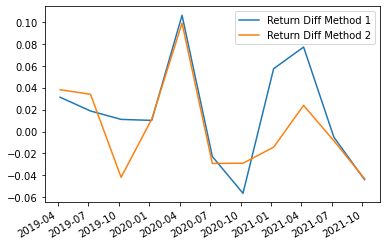

In [43]:
comp_performance.plot(y=["Return Diff Method 1", "Return Diff Method 2"])

<AxesSubplot:>

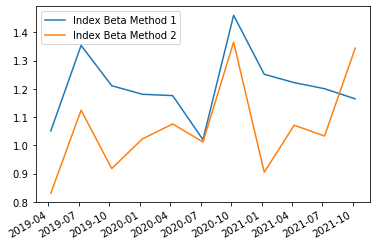

In [44]:
comp_performance.plot(y=["Index Beta Method 1", "Index Beta Method 2"])